# Sequence to sequence models

Sequence to sequence models are typically used for tasks like translation, summarization, question answering,...

## Install dependencies

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Feb__8_05:53:42_Coordinated_Universal_Time_2023
Cuda compilation tools, release 12.1, V12.1.66
Build cuda_12.1.r12.1/compiler.32415258_0


In [10]:
%pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124
%pip install tokenizers==0.20.3 transformers==4.46.3 pandas==2.2.3 datasets==3.1.0 sentencepiece==0.2.0 sacremoses==0.1.1

Looking in indexes: https://download.pytorch.org/whl/cu124, https://pypi.ngc.nvidia.comNote: you may need to restart the kernel to use updated packages.

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/897.5 kB ? eta -:--:--
   - -------------------------------------- 30.7/897.5 kB 1.4 MB/s eta 0:00:01
   ---------- ----------------------------- 225.3/897.5 kB 3.5 MB/s eta 0:00:01
   -------------------- ------------------- 450.6/897.5 kB 4.0 MB/s eta 0:00:01
   ----------------------------- ---------- 655.4/897.5 kB 4.6 MB/s eta 0:00:01
   ---------------------------------------- 897.5/897.5 kB 4.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/97.9 kB ? eta -:--:--
   ---------------------------------------- 97.9/97.9 kB 5.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/301.8 kB ? eta -:--:--
   ------------------------------------ --- 276.5/301.8 kB 5.8 MB/s eta 0:00:01
   -


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Load in a trained Albanian - English model

### Using a pipeline

In [11]:
from transformers import pipeline

pipe = pipeline("translation", model="Helsinki-NLP/opus-mt-sq-en", device="cuda")     

In [14]:
pipe("Më pëlqen të lexoj libra")

[{'translation_text': 'I like reading books.'}]

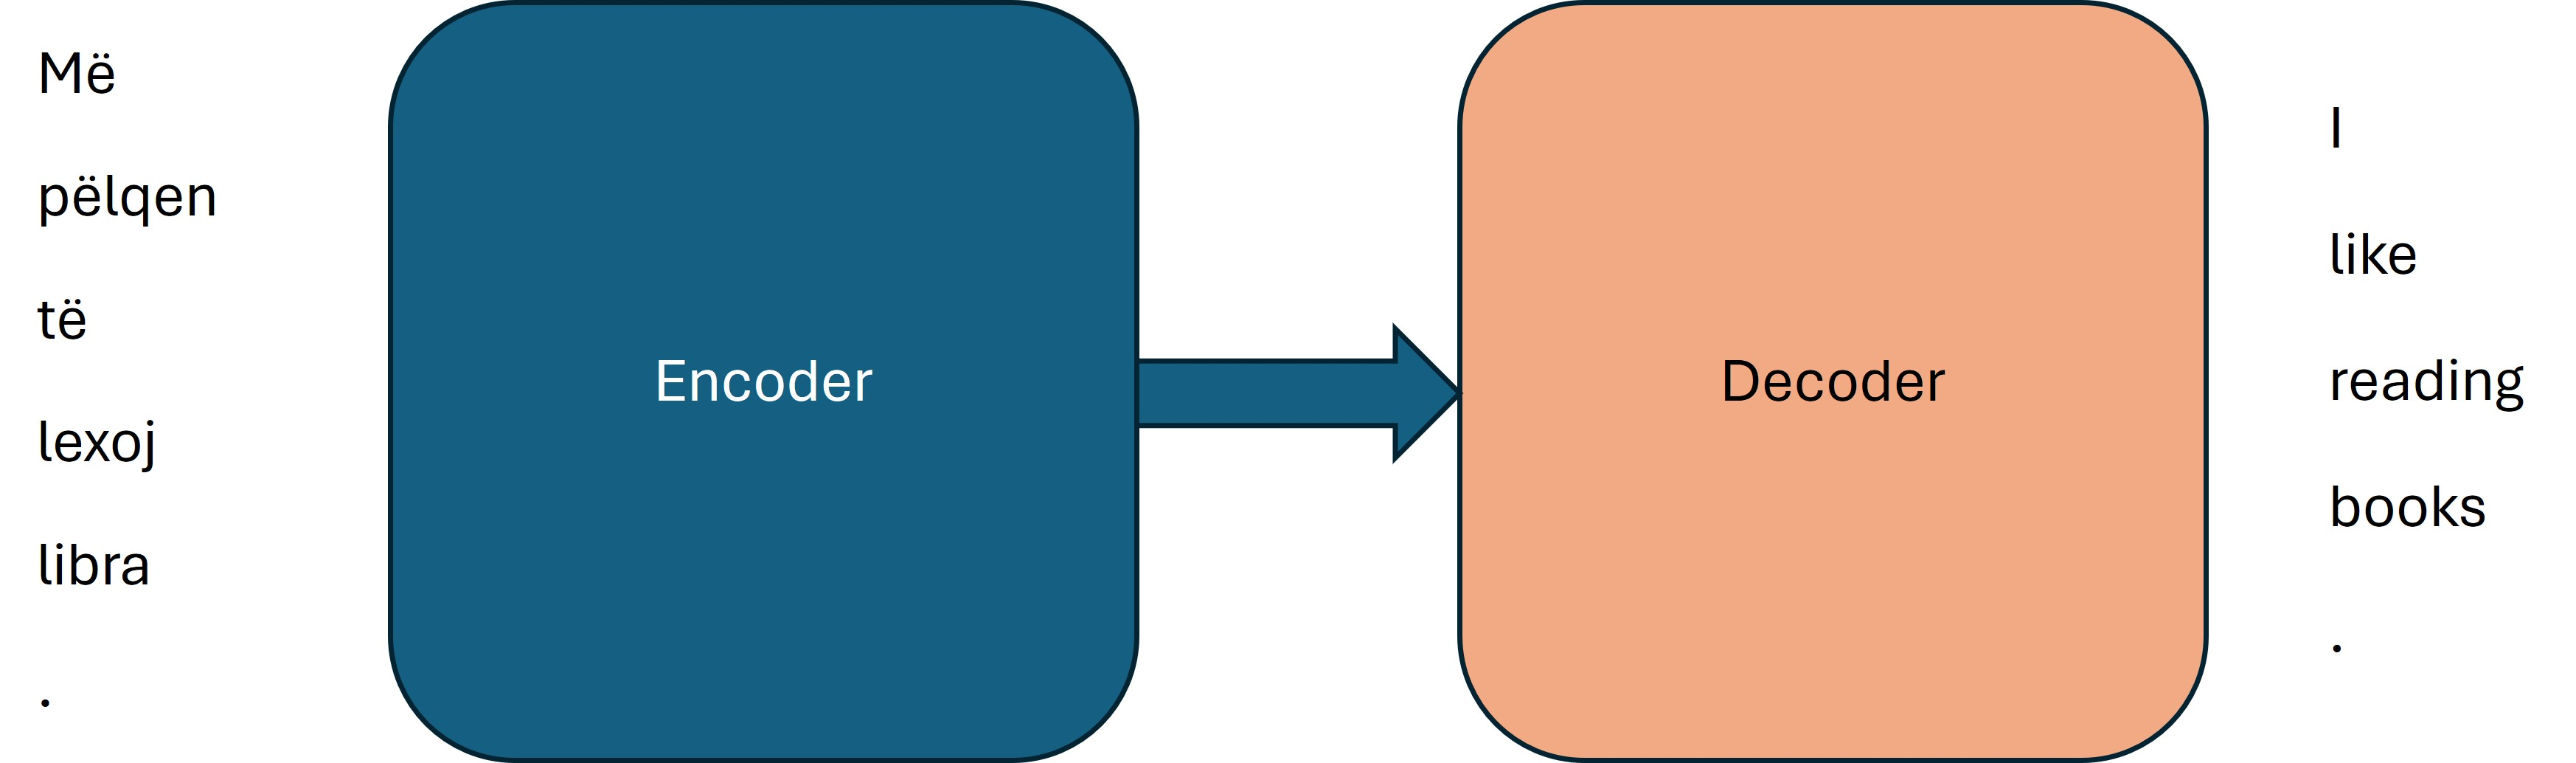

In [13]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-sq-en")

# Input sentence in Albanian
input_sentence = "Më pëlqen të lexoj libra."

# Tokenize the sentence to see the tokens
tokens = tokenizer.tokenize(input_sentence)

print("Tokens:", tokens)

Tokens: ['▁Më', '▁pëlqen', '▁të', '▁lexoj', '▁libra', '.']


In [4]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-sq-en")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-sq-en").to("cuda")

c:\Users\449234985\lm-tutorial\venv\Lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [5]:
tokenizer("Më pëlqen të lexoj libra.")

{'input_ids': [175, 1162, 4, 9248, 7203, 2, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [8]:
model.generate("Më pëlqen të lexoj libra.")

AttributeError: 'str' object has no attribute 'shape'